# ENEL 645 Assignment 2

Tobin Eberle

Tom Wilson

Jeff Wheeler

Ryan Baker

### Ensure Virtual Environment is Activated

In [118]:
!which python

/Users/ryanb/miniforge3/envs/pytorch/bin/python


Environment is shown in `../envs/pytorch/..`, indicating that the `pytorch` virtual environment has been activated.

### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import torch
from garbage_classifier_fusion import FusionNetwork, FusionDataSet, predict
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision import transforms
from transformers import DistilBertModel, DistilBertTokenizer


### Define Constants
Note: Local copy of Test data was used to avoid TALC connection requirement

In [2]:
TEST_PATH = "./CVPR_2024_dataset_Test"
NUM_EPOCHS = 5
BATCH_SIZE = 32
NUM_FUSION_FEATURES = 250
WEIGHT_DECAY = 1e-04
LEARNING_RATE = 0.00005
DROPOUT = 0.3
MAX_LENGTH = 200


### Variable & Model Instantiations

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
test_dataset = FusionDataSet(transform, tokenizer, TEST_PATH, MAX_LENGTH)
test_loader = DataLoader(test_dataset, shuffle = False)
imageModel = resnet18(weights='ResNet18_Weights.DEFAULT')
textModel = DistilBertModel.from_pretrained('distilbert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FusionNetwork(imageModel, textModel, 4, NUM_FUSION_FEATURES, DROPOUT).to(device)


### Load Weights
Including `map_location` is necessary as the notebook was run on a cpu device but trained on a CUDA device.

In [5]:
model.load_state_dict(torch.load("best_fusion_model.pth", map_location=device));


In [6]:
test_predictions, test_classes = predict(model, test_loader, device)

Test Accuracy: 85.49%


In [7]:
print(f"Test Prediction Length: {len(test_predictions)}")
print(f"Test Classes Length: {len(test_classes)}")


Test Prediction Length: 3432
Test Classes Length: 3432


### Confusion Matrix
Note the classes are indexed as follows:

0 - Black

1 - Blue

2 - Green

3 - TTR

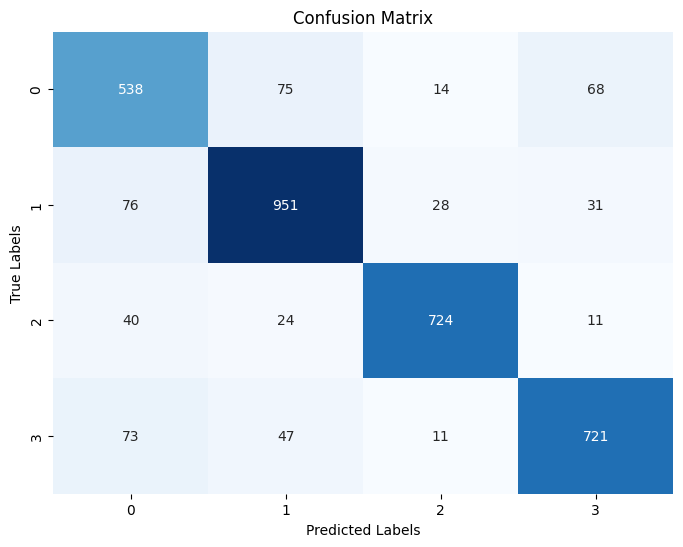

In [8]:
cm = confusion_matrix(test_classes, test_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Helper Functions and Variables for Further Analysis

In [9]:
test_predictions = pd.Series(test_predictions, name='Predicted')
test_classes = pd.Series(test_classes, name='Actual')
results_df = pd.concat([test_classes, test_predictions], axis=1)

In [10]:
def top_misclassifications(cm, top_n=3):
    misclassifications = []
    window_size = cm.shape[0]  # Window covers the entire confusion matrix

    # Iterate over the confusion matrix using a sliding window
    for i in range(window_size):
        for j in range(window_size):
            if i != j:  # Exclude diagonal (correct classifications)
                misclassifications.append({'actual': i, 'predicted': j, 'count': cm[i, j]})

    misclassifications = sorted(misclassifications, key=lambda x: x['count'], reverse=True)

    return misclassifications[:top_n]

top_3_misclassifications = top_misclassifications(cm, top_n=3)
top_3_misclassifications


[{'actual': 1, 'predicted': 0, 'count': 76},
 {'actual': 0, 'predicted': 1, 'count': 75},
 {'actual': 3, 'predicted': 0, 'count': 73}]

In [11]:
def get_index_samples(df, actual, predicted, n_samples=3):
    return df[(df['Actual'] == actual) & (df['Predicted'] == predicted)].sample(n_samples).index.values

In [12]:
def view_sample_images(df, actual, predicted, n_samples=5):
    samples = get_index_samples(df, actual, predicted, n_samples)
    actual = ''
    predicted = ''
    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(samples):
        plt.subplot(1, 5, i + 1)
        actual = results_df['Actual'][idx]
        predicted = results_df['Predicted'][idx]
        plt.imshow(plt.imread(test_dataset.images[idx]))
        plt.axis('off')
        plt.title(f"{"/".join(test_dataset.images[idx].split('/')[2:])}", fontsize=8)
    plt.suptitle(f"Images of Class {actual} Misclassified as Class {predicted}")
    plt.show()

### Check Images for Top 3 Misclassifications

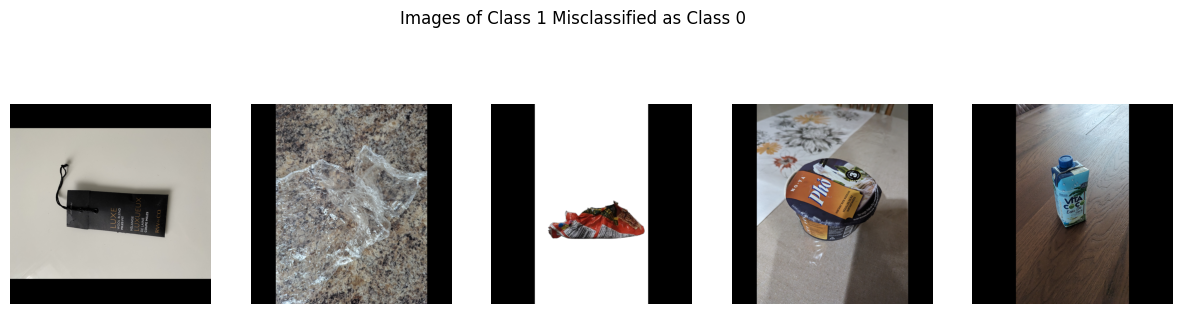

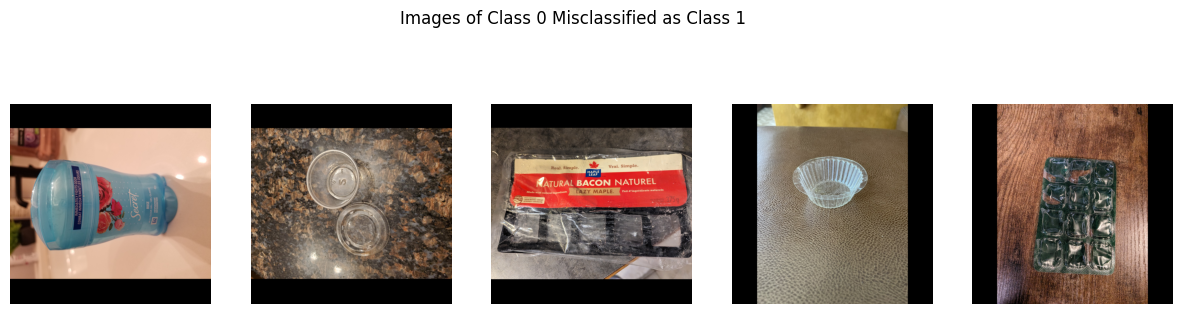

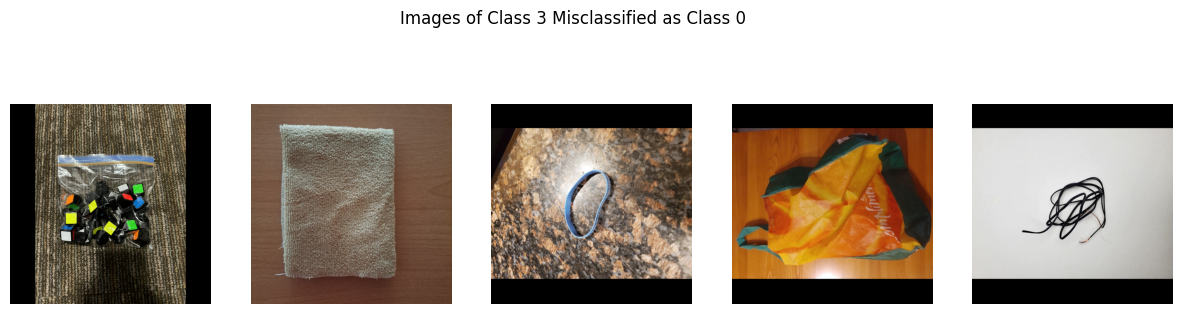

In [13]:
for i, misclassification in enumerate(top_3_misclassifications):
    view_sample_images(results_df, misclassification['actual'], misclassification['predicted'], n_samples=5)

Observations:
- Common items like plastics, containers, papers (class 1, blue) are often mislabeled as class 0 (black). This is supported by the confusion matrix which shows the most misclassifications between these two classes.
- There might be inaccurated labelling in our dataset, for example shopping bags, elastic bands could be considered class 0 (black) but are labelled as class 3 (TTR). Additionally, some class 0 (black) items, such as the take out containers are likely recyclable (class 1, blue).
- Some datasamples are poor quality, e.g. multi-coloured backgrounds or hard to define the item as in the saranwrap image.

Some observations not shown in the above images but seen in previous iterations:
- Light bulbs seem to be confusing to the model; though they are consistently labeled as Class 0 (black), they seem to regularly get misclassified into Class 3 (TTR).
- Aerosol cans and containers for hard chemicals (Class 0, black) have similar appearance to clean recyclable containers (Class 1, blue) and garbage containers (Class 3, TR).
- Black bin (Class 0, black) is a highly variable category with objects that may appear to be similar to items in the blue bin (Class 1, blue) and other (Class 3, TTR). It makes sense that a classifier would get some of these items wrong, because humans do too!